In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
# Constants

x_1 = 0
x_2 = 30000
x_3 = 100000
z_H = 100
D = 100
s_d = 7*D
s_c = 7*D
U_0 = 10
kappa = 0.4 # Von Karman constant [-]
z_0 = 0.0001 # surface rughness length [m]
C_T = 0.7

In [3]:
def calculate_wind_speed(x_1, x_2, x_3, z_H, D, C_T, s_d, s_c):

    ct = (np.pi * C_T * D**2)/(8 * s_d * s_c)

    nu_star = 28 * np.sqrt(ct)
    
    beta =  nu_star / (1 + nu_star)
    
    z_0WF = z_H * (1 + D/(2 * z_H))**beta * np.exp(-kappa * (ct + (kappa/np.log((z_H / z_0) * (1 - D/(2 * z_H))**beta))**2)**-0.5)

    x_1 = x_1
    x_2 = x_2
    x_3 = x_3
    x = np.linspace(x_1, x_3, x_3)

    h1 = np.full_like(x, np.nan, dtype=float)
    h2 = np.full_like(x, np.nan, dtype=float)

    h1[x > x_1] = z_H + ((x[x > x_1]) / z_0WF)**(4/5)
    h2[x > x_2] = ((x[x>x_2]-x_2)/z_0WF)**(4/5)

    uw = np.full_like(x, np.nan, dtype=float)
    uw[0] = U_0

    idx1 = h1 >= z_H
    uw[idx1] = U_0 * (np.log(h1[idx1] / z_0) * np.log(z_H / z_0WF)) / (np.log(h1[idx1] / z_0WF) * np.log(z_H/z_0))

    idx2 = (x > x_2) & (h2 >= z_H)
    uw[idx2] = U_0 * (np.log(h1[idx2] / z_0) * np.log(h2[idx2] / z_0WF)) / (np.log(h1[idx2] / z_0WF) * np.log(h2[idx2] / z_0))

    return x, uw

In [4]:
# Initialize thrust curve

u = np.arange(0, 26, .5)  # [m/s]
CT = np.array([0, 0, 0, 0, 0.78, 0.77, 0.78, 0.78, 0.77, 0.77, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.77, 0.77, 0.77, 0.76, 0.73, 0.7, 0.68, 0.52, 0.42,
      0.36, 0.31, 0.27, 0.24, 0.22, 0.19, 0.18, 0.16, 0.14, 0.13, 0.12, 0.11, 0.1, 0.09, 0.08, 0.08, 0.08, 0.07, 0.07, 0.06, 0.06, 0.06,
      0.05, 0.05, 0.05, 0.04, 0])
tc = np.rec.fromarrays([u, CT], names='u, CT')

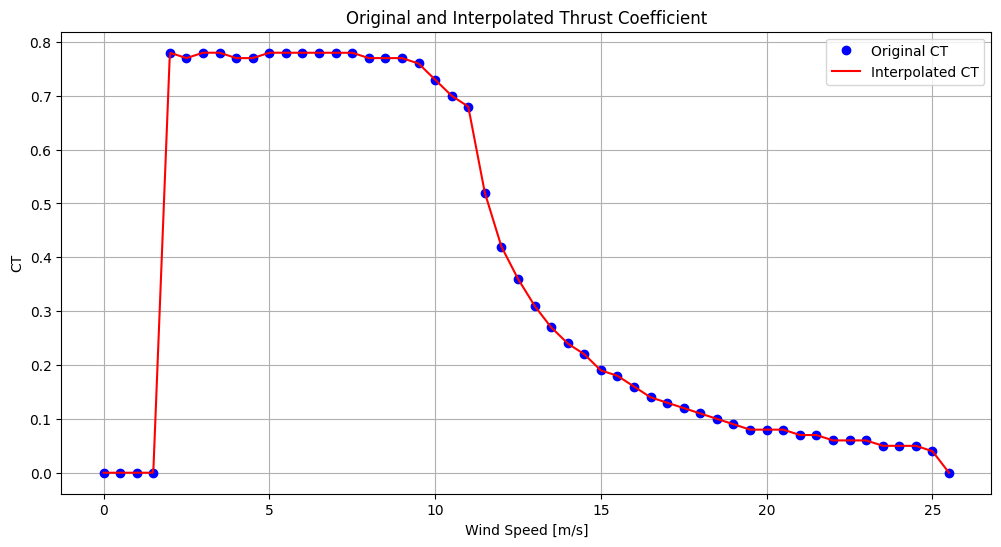

In [5]:
# Interpolate thrust curve
u_interp = np.linspace(u.min(), u.max(), 1000)
CT_interp = interp1d(u, CT, kind='linear')(u_interp)

tc_interp = np.rec.fromarrays([u_interp, CT_interp], names='u, CT')

plt.figure(figsize=(12, 6))
plt.plot(u, CT, 'o', label='Original CT', color='blue')
plt.plot(u_interp, CT_interp, '-', label='Interpolated CT', color='red')
plt.xlabel('Wind Speed [m/s]')
plt.ylabel('CT')
plt.title('Original and Interpolated Thrust Coefficient')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [6]:
def calculate_wind_speed_iterative(x_1, x_2, x_3, z_H, D, s_d, s_c, uw_initial, tol=0.01, max_iter=100):

    x = np.linspace(x_1, x_3+1, x_3+1)
    uw_x = uw_initial.copy()  # Initial guess

    for iteration in range(max_iter):
        # Interpolate to get CT from current uw_x
        idx = np.abs(uw_x[:, None] - tc_interp.u).argmin(axis=1)
        CT_x = tc_interp.CT[idx]

        ct = (np.pi * CT_x * D**2) / (8 * s_d * s_c)

        nu_star = 28 * np.sqrt(ct)
        beta = nu_star / (1 + nu_star)

        z_0WF = z_H * (1 + D/(2 * z_H))**beta * np.exp(
            -kappa * (ct + (kappa / np.log((z_H / z_0) * (1 - D / (2 * z_H))**beta))**2)**-0.5
        )

        h1 = np.full_like(x, np.nan, dtype=float)
        h2 = np.full_like(x, np.nan, dtype=float)

        h1[x >= x_1] = z_H + ((x[x >= x_1]) / z_0WF)**(4/5)
        h2[x > x_2] = ((x[x > x_2] - x_2) / z_0WF[x > x_2])**(4/5)

        uw_new = np.full_like(x, np.nan, dtype=float)

        idx1 = h1 >= z_H
        uw_new[idx1] = U_0 * (
            np.log(h1[idx1] / z_0) * np.log(z_H / z_0WF)
        ) / (
            np.log(h1[idx1] / z_0WF) * np.log(z_H / z_0)
        )

        idx2 = (x > x_2) & (h2 >= z_H)
        uw_new[idx2] = U_0 * (
            np.log(h1[idx2] / z_0) * np.log(h2[idx2] / z_0WF[idx2])
        ) / (
            np.log(h1[idx2] / z_0WF[idx2]) * np.log(h2[idx2] / z_0)
        )

        # Check convergence
        delta = np.nanmax(np.abs(uw_new - uw_x))
        print(f"Iteration {iteration + 1}, max delta uw: {delta:.4f} m/s")

        if delta < tol:
            break

        uw_x = uw_new.copy()

    return x, uw_x, ct


Iteration 1, max delta uw: 0.2599 m/s
Iteration 2, max delta uw: 0.0112 m/s
Iteration 3, max delta uw: 0.0014 m/s


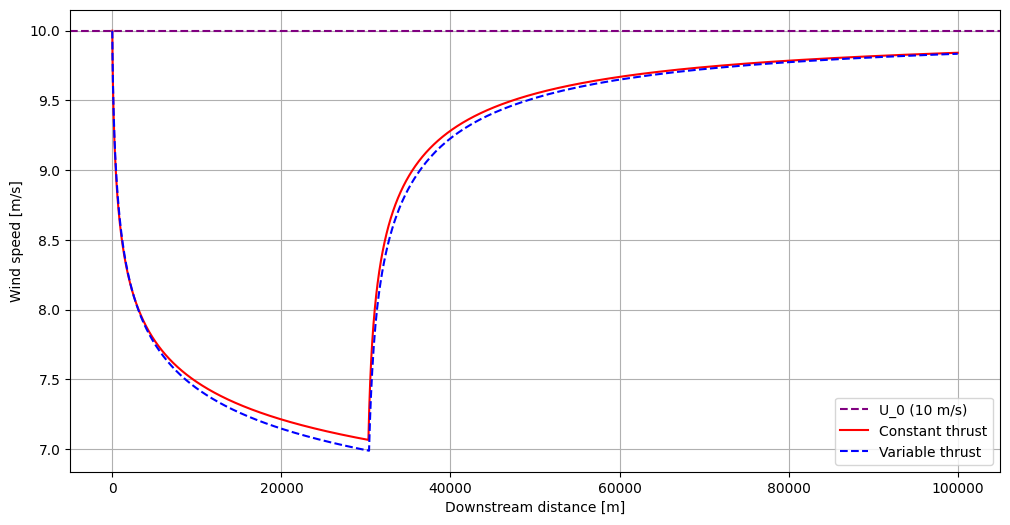

In [7]:
# uw / x plot with C_T and C_T_var

x, uw = calculate_wind_speed(x_1, x_2, x_3+1, z_H, D, C_T, s_d, s_c)
x_x, uw_x, ct_var = calculate_wind_speed_iterative(x_1, x_2, x_3, z_H, D, s_d, s_c, uw)

plt.figure(figsize=(12, 6))
plt.axhline(y=U_0, color='purple', linestyle='--', label=f'U_0 ({U_0:.0f} m/s)')
plt.plot(x, uw, label='Constant thrust', color='red')
plt.plot(x_x, uw_x, label='Variable thrust', color='blue', linestyle='dashed')
plt.xlabel('Downstream distance [m]')
plt.ylabel('Wind speed [m/s]')
plt.legend(loc='best')
plt.grid(True)
plt.show()

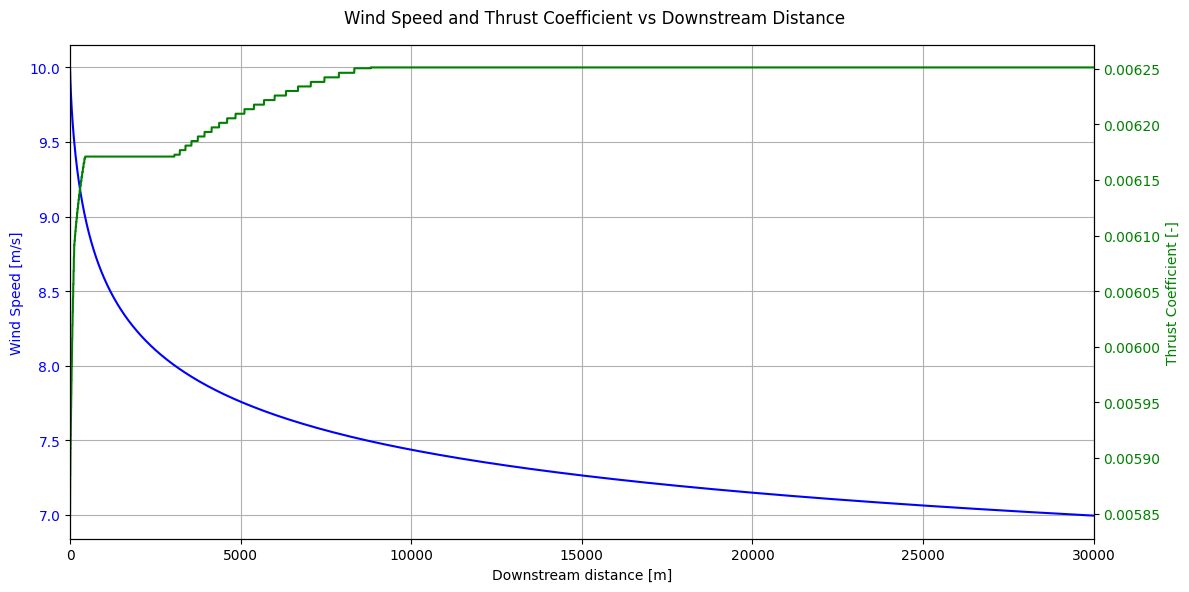

In [ ]:
# uw & c_t / x plot

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot uw_x on the primary y-axis
ax1.plot(x_x, uw_x, label='Wind Speed (uw_x)', color='blue')
ax1.set_xlabel('Downstream distance [m]')
ax1.set_ylabel('Wind Speed [m/s]', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a secondary y-axis for ct_var
ax2 = ax1.twinx()
ax2.plot(x_x, ct_var, label='Thrust Coefficient (ct_var)', color='green')
ax2.set_ylabel('Thrust Coefficient [-]', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add a title and show the plot
fig.suptitle('Wind Speed and Thrust Coefficient vs Downstream Distance')
fig.tight_layout()
plt.xlim(x_1, x_2)
plt.show()